In [1]:
#STEP: IMPORTS

#import json
import pandas as pd
import numpy as np
import sqlite3
from pandas.io import sql
import cPickle as pickle
import scipy.sparse
from operator import itemgetter
from pprint import pprint
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import pprint 
pp = pprint.PrettyPrinter(depth=6)
from wordcloud import WordCloud
from PIL import Image
import cv2

from textblob import TextBlob, Word
from langdetect import detect

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import roc_curve, auc

### DATA PREP / EXPLORATION AND CLEANING

I'll be using two files from the yelp datasets that are available; business & review

##### Data Dictionary

In [2]:
#reviews file
"Contains full review text data including the user_id that wrote the review and the business_id the review is written for."
data_dict_reviews = {'review_id': '22 character unique review id',
            'user_id': '22 character unique user id, maps to other yelp file; user(may not yet be used)', 
            'business_id': '22 character unique user id, maps to other yelp file; business(may not yet be used)',
            'stars': 'star rating',
            'date': 'date formatted YYYY-MM-DD',
            'text': 'the review itself, user input freetext',
            'useful': 'number of useful votes received',
            'funny': 'number of funny votes received',
            'cool': 'number of cool votes received'}

#business file
"Contains business data including location data, attributes, and categories."
data_dict_business = {'business_id': '22 character unique string business id',
            'name': 'the business name', 
            'neighborhood': 'the neighborhood name where the business is located',
            'address': 'the full address of the business',
            'city': 'the city name where the business is located',
            'state': '2 character state code,',
            'postal code': 'the postal code',
            'latitude': 'latitude of business location',
            'longitude': 'longitude of business location',
            'stars': 'star rating, rounded to half-stars',
            'review_count': 'number of reviews',
            'is_open': '0 or 1 for closed or open, respectively',
            'attributes': 'dictionary of business attributes to values. e.g. {"garage": false}',
            'categories': 'an array of strings of business categories',
            'hours': 'an object of key day to value hours, hours are using a 24hr clock'}

In [3]:
#READ in JSONL IN AS PD.. (TAKES A WHILE)
    #the files are actually JSONL, separated by line
if 0 == 1:
    reviews = pd.read_json("~/Documents/capstone_data/yelp/review.json", lines=True)
    businesses = pd.read_json("~/Documents/capstone_data/yelp/business.json", lines=True)

In [4]:
#CONVERTING PD TO CSV.. (SO NO NEED TO RE RUN EACH TIME)
#NEEDS TO BE CONVERTED TO CSV PRIOR TO SQL work. 
if 1 == 0: 
    reviews.to_csv("~/Documents/capstone_data/yelp/reviews.csv", encoding='utf-8', index = False)
    businesses.to_csv("~/Documents/capstone_data/yelp/businesses.csv", encoding='utf-8', index = False)#checkins.to_csv("checkins.csv", encoding='utf-8')

In [6]:
#READ IN CSV INTO NOTEBOOK
revs = pd.read_csv('~/Documents/capstone_data/yelp/reviews.csv', encoding = 'utf-8')
biz = pd.read_csv('~/Documents/capstone_data/yelp/businesses.csv', encoding = 'utf-8')

##### Explore, clean and explain the data.

In [7]:
revs.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,uYHaNptLzDLoV_JZ_MuzUA,0,2016-07-12,0.0,VfBHSwC5Vz_pbFluy07i9Q,5.0,My girlfriend and I stayed here for 3 nights a...,0.0,cjpdDjZyprfyDG3RlkVG3w
1,uYHaNptLzDLoV_JZ_MuzUA,0,2016-10-02,0.0,3zRpneRKDsOPq92tq7ybAA,3.0,If you need an inexpensive place to stay for a...,0.0,bjTcT8Ty4cJZhEOEo01FGA
2,uYHaNptLzDLoV_JZ_MuzUA,0,2015-09-17,0.0,ne5WhI1jUFOcRn-b-gAzHA,3.0,Mittlerweile gibt es in Edinburgh zwei Ableger...,0.0,AXgRULmWcME7J6Ix3I--ww
3,uYHaNptLzDLoV_JZ_MuzUA,0,2016-08-21,0.0,llmdwOgDReucVoWEry61Lw,4.0,Location is everything and this hotel has it! ...,0.0,oU2SSOmsp_A8JYI7Z2JJ5w
4,uYHaNptLzDLoV_JZ_MuzUA,0,2013-11-20,0.0,DuffS87NaSMDmIfluvT83g,5.0,gute lage im stadtzentrum. shoppingmeile und s...,0.0,0xtbPEna2Kei11vsU-U2Mw


In [8]:
revs.shape

(4736899, 9)

In [9]:
revs.dtypes

business_id     object
cool             int64
date            object
funny          float64
review_id       object
stars          float64
text            object
useful         float64
user_id         object
dtype: object

In [10]:
print 'cool unique :', len(revs.cool.unique())
print 'funny unique :', len(revs.funny.unique())
print 'stars unique :', len(revs.stars.unique())
print 'useful unique :', len(revs.useful.unique())

cool unique : 160
funny unique : 153
stars unique : 6
useful unique : 206


In [11]:
revs.stars.value_counts()

5.0    1988003
4.0    1135830
1.0     639849
3.0     570819
2.0     402396
Name: stars, dtype: int64

In [12]:
revs.describe()

,cool,funny,stars,useful
count,4.736899e+06,4.736897e+06,4.736897e+06,4.736895e+06
mean,5.096598e-01,4.029171e-01,3.724048e+00,9.882925e-01
std,1.960373e+00,1.721954e+00,1.421104e+00,2.600022e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,5.000000e+00,1.000000e+00
max,5.130000e+02,6.310000e+02,5.000000e+00,1.125000e+03


In [19]:
revs.text.str.len().max()

5000.0

In [20]:
revs.text.str.len().min()

1.0

In [21]:
biz.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,691 Richmond Rd,"{u'RestaurantsPriceRange2': 2, u'BusinessParki...",YDf95gJZaq05wvo7hTQbbQ,"[Shopping, Shopping Centers]",Richmond Heights,"{u'Monday': u'10:00-21:00', u'Tuesday': u'10:0...",1,41.541716,-81.493116,Richmond Town Square,NaN,44143,17,2.0,OH
1,2824 Milton Rd,"{u'GoodForMeal': {u'dessert': False, u'latenig...",mLwM-h2YhXl2NCgdS84_Bw,"[Food, Soul Food, Convenience Stores, Restaura...",Charlotte,"{u'Monday': u'10:00-22:00', u'Tuesday': u'10:0...",0,35.236870,-80.741976,South Florida Style Chicken & Ribs,Eastland,28215,4,4.5,NC
2,337 Danforth Avenue,"{u'BusinessParking': {u'garage': False, u'stre...",v2WhjAB3PIBA8J8VxG3wEg,"[Food, Coffee & Tea]",Toronto,"{u'Monday': u'10:00-19:00', u'Tuesday': u'10:0...",0,43.677126,-79.353285,The Tea Emporium,Riverdale,M4K 1N7,7,4.5,ON
3,"7702 E Doubletree Ranch Rd, Ste 300",{},CVtCbSB1zUcUWg-9TNGTuQ,"[Professional Services, Matchmakers]",Scottsdale,"{u'Tuesday': u'9:00-17:00', u'Friday': u'9:00-...",1,33.565082,-111.916400,TRUmatch,NaN,85258,3,3.0,AZ
4,4719 N 20Th St,"{u'GoodForMeal': {u'dessert': False, u'latenig...",duHFBe87uNSXImQmvBh87Q,"[Sandwiches, Restaurants]",Phoenix,{},0,33.505928,-112.038847,Blimpie,NaN,85016,10,4.5,AZ


In [22]:
biz.shape

(156639, 15)

In [23]:
biz.dtypes

address          object
attributes       object
business_id      object
categories       object
city             object
hours            object
is_open           int64
latitude        float64
longitude       float64
name             object
neighborhood     object
postal_code      object
review_count      int64
stars           float64
state            object
dtype: object

In [ ]:
#USE SQL TO CREATE RESTUAURANT ONLY DATABASE;
    #using 'categories' & 'business_id' from the business file; biz
    #and inner-joining the revs dataset with 'business_id' from biz that contain 'restaurant' in the category

In [ ]:
db_connection = sqlite3.connect('../results.db.sqlite')

biz.to_sql(name = "bizS", con=db_connection, if_exists = "replace", index = False)
revs.to_sql(name = "revS", con=db_connection, if_exists = "replace", index = False)

rest_revs_sql = sql.read_sql('SELECT r.*, b.categories FROM revsS AS r INNER JOIN bizS AS b ON r.business_id = b.business_id WHERE b.categories LIKE "%Restaurant%"', con = db_connection)

#rest_revs_sql is STILL giving me an unamed column!

In [ ]:
rest_revs_sql.shape

In [ ]:
rest_revs_sql.columns

In [ ]:
rest_revs_sql.head(10)

In [ ]:
rest_revs_sql.isnull().sum()
rest_revs_sql.dropna(inplace=True)

In [ ]:
#export to csv
rest_revs_sql.to_csv("~/Documents/capstone_data/yelp/rest_revs_s.csv", encoding='utf-8', index = False)

In [25]:
    #READ IN FROM HERE..
rest_revs = pd.read_csv('~/Documents/capstone_data/yelp/rest_revs_s.csv', encoding = 'utf-8')

In [ ]:
########################################################################

### EDA / STEP 3;

In [ ]:
#EDA;
"""
GOAL; A brief report that describes your EDA and analysis so far,
as well as your concrete next steps

- create a progress report that documents;
--approach to EDA, 
--initial results, roadblocks setbacks, surprises.

- perform inital descriptive and visual analysis of data
-- identify outliers
-- summarize risks and limitiations.

- Discuss proposed next steps.

"""

In [55]:
    #READ IN FROM HERE..
rest_revs = pd.read_csv('~/Documents/capstone_data/yelp/rest_revs_s.csv', encoding = 'utf-8')

In [26]:
rest_revs.head(2)

,Unnamed: 0,business_id,cool,date,funny,review_id,stars,text,useful,user_id,categories
0,1558471,mLwM-h2YhXl2NCgdS84_Bw,1,2016-06-18,0.0,exUbigDEviVau7r6TQ24Ug,4.0,So this place is in the c-store. A little skep...,0.0,rOhyDyMWN7ckYDNA4C-JDA,"[Food, Soul Food, Convenience Stores, Restaura..."
1,1558472,mLwM-h2YhXl2NCgdS84_Bw,12,2016-03-06,5.0,cyYjLJjuvGngUR4mMI9eQQ,4.0,South Florida resides on the east side of Char...,14.0,9IRuYmy5YmhtNQ6ei1p-uQ,"[Food, Soul Food, Convenience Stores, Restaura..."


In [27]:
rest_revs = rest_revs.drop(['Unnamed: 0'], axis=1)

In [28]:
rest_revs.shape

(2927859, 10)

In [29]:
rest_revs.dtypes

business_id     object
cool             int64
date            object
funny          float64
review_id       object
stars          float64
text            object
useful         float64
user_id         object
categories      object
dtype: object

##### plot distribution of star ratings

In [30]:
rest_revs.stars = rest_revs.stars.apply(lambda x: int(x))

In [31]:
rest_revs['stars'].value_counts()

5    1083624
4     818804
3     417500
1     322283
2     285648
Name: stars, dtype: int64

In [97]:
#take a random look.
rest_revs.iloc[89,:].text

'Typical Red Lobster.  Busy.  Good service. Food is delish.... cant get enough of those biscuits!'

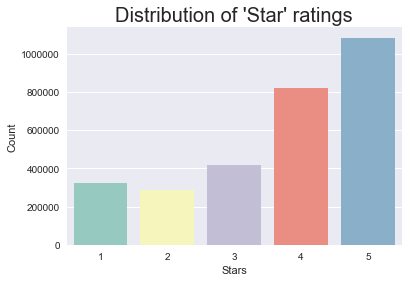

In [41]:
stardist = sns.countplot(x="stars", data=rest_revs, palette="Set3")

stardist.axes.set_title("Distribution of 'Star' ratings", fontsize =20)
stardist.set(xlabel='Stars', ylabel='Count')
#sns.set(font_scale=1)

plt.show()

Clearly a negative skewed graph; NTS consider bootstrapping. 

##### plot distribution text length 

In [42]:
rest_revs['text_len'] = rest_revs.text.apply(lambda x: len(x))

In [43]:
rest_revs.text_len.describe()

count    2.927859e+06
mean     6.055518e+02
std      5.631781e+02
min      1.000000e+00
25%      2.350000e+02
50%      4.280000e+02
75%      7.800000e+02
max      5.000000e+03
Name: text_len, dtype: float64

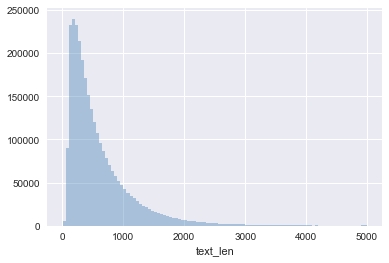

In [44]:
sns.distplot(rest_revs['text_len'], kde=False, color='steelblue', bins=100)
plt.show()

##### let's investigate the distribution of text len further, and identify any possible outliers

In [174]:
#sns.set(font_scale=2)

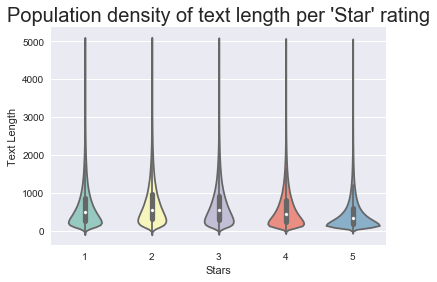

In [46]:
popstar = sns.violinplot(x="stars", y="text_len", data=rest_revs, palette="Set3")
popstar.axes.set_title("Population density of text length per 'Star' rating", fontsize =20)
popstar.set(xlabel='Stars', ylabel='Text Length')
#sns.set(font_scale=1)

plt.show()


In [47]:
print "Min text len:", rest_revs.text_len.max(), "Max text len:", rest_revs.text_len.min()

Min text len: 5000 Max text len: 1


Judging by the population distribution of LEN per star, there is a patten in that all star ratings contain a very low amount of text that is longer than 2000 characters. 
These reviews, along with single character reviews may prove to be outliers. 

lets count just how many items are text have len> 2000 in the dataset. And how many reviews are less than 3 characters long. Let's not yet look into 3 letter words being potential outliers, I can assume some three lettter words are sentimental enought for a restaurant review..!

In [48]:
print "text len >2000 count:", rest_revs[(rest_revs['text_len'] >= 2000)].shape[0]

perc_len_2000 = rest_revs[(rest_revs['text_len'] >= 2000)].shape[0] / float(len(rest_revs)) *100 
print "% of text len >2000 count: {:0.2f} %\n".format(perc_len_2000)

print "text len <3 count:", rest_revs[(rest_revs['text_len'] < 3)].shape[0]

perc_len_2000 = rest_revs[(rest_revs['text_len'] <3 )].shape[0] / float(len(rest_revs)) *100 
print "% of text len >2000 count: {:0.5f} %".format(perc_len_2000)

text len >2000 count: 89568
% of text len >2000 count: 3.06 %

text len <3 count: 14
% of text len >2000 count: 0.00048 %


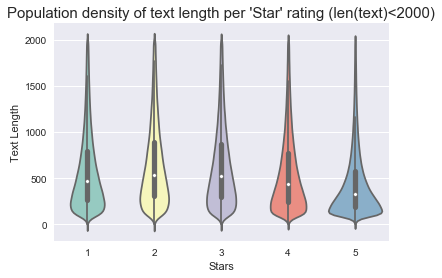

In [49]:
#Lets take a look into the ~96% of our data that contain text below 2000 characters 
popstar2 = sns.violinplot(x="stars", y="text_len", data=rest_revs[(rest_revs['text_len'] < 2000)], palette="Set3")
popstar2.axes.set_title("Population density of text length per 'Star' rating (len(text)<2000)", fontsize =15)
popstar2.set(xlabel='Stars', ylabel='Text Length')
plt.show()
#fix zero 

The length of text population density stands out from other star reviews; in that there is a much higher proportion of reviews that have a length between 200 and 250 characters long. Compared to other stars, the tail also decreases at a faster rate with regard to text length.

In [36]:
####################################################################

In [50]:
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [70]:
#PERFORM SENTIMENT ANALYSIS OF EACH TEXT (VERY SLOW)
if 0 == 1: #i ran this in an AWS instance. 
    rest_revs['sentiment'] = rest_revs.text.apply(detect_sentiment)
    
    rest_revs_ss = rest_revs[['stars','sentiment','text_len']]
    #export as CSV for the "here's one I prepared earlier"
    rest_revs_ss.to_csv("rest_revs_ss.csv", encoding='utf-8', index = False)

#load in pre-prepared doc
rest_revs_ss_2 = pd.read_csv('~/Documents/capstone_data/yelp/rest_revs_ss.csv')

In [56]:
#CHECK HEAD/SHAPE
rest_revs_ss_2.head(5)

,stars,sentiment,text_len
0,4.0,0.193333,294
1,4.0,0.233185,667
2,5.0,0.546875,288
3,5.0,-0.158661,151
4,5.0,0.018750,282


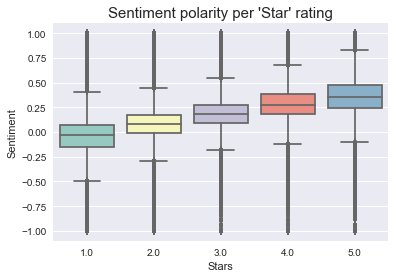

In [57]:
sentimentstar = sns.boxplot(x="stars", y="sentiment", data=rest_revs_ss_2, palette="Set3")
sentimentstar.axes.set_title("Sentiment polarity per 'Star' rating", fontsize =15)
sentimentstar.set(xlabel='Stars', ylabel='Sentiment')
plt.show()


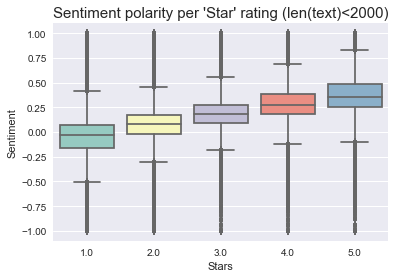

In [58]:
#Lets again take a look into the ~96% of our data that contain text below 2000 characters 
sentimentstar2 = sns.boxplot(x="stars", y="sentiment", data=rest_revs_ss_2[(rest_revs_ss_2['text_len'] < 2000)], palette="Set3")
sentimentstar2.axes.set_title("Sentiment polarity per 'Star' rating (len(text)<2000)", fontsize =15)
sentimentstar2.set(xlabel='Stars', ylabel='Sentiment')
plt.show()


As expected, not a huge change in sentiment per text per star;
we have only filtered out 3% of the data. 

#### Below I will investigate text frequency in total and then broken down per star rating


In [79]:
if 0 == 1:   
    #remove english stop words by restting the count vectorizer;
    cvec = CountVectorizer(stop_words='english')

    #fit our new vectorizer; 
    cvec.fit(rest_revs['text'])

    #transform the training data; 
    cvec_mat = cvec.transform(rest_revs['text'])

    #save transformed sparse matrix, cvec_mat
    scipy.sparse.save_npz('~/Documents/capstone_data/yelp/cvec_mat.npz', cvec_mat)
    
    #save cvec
    with open('/Users/jackcunningham/Documents/capstone_data/yelp/cvec.pkl', 'w') as f:
        pickle.dump(cvec, f)
    
if 1 == 1:
    cvec_mat = scipy.sparse.load_npz('/Users/jackcunningham/Documents/capstone_data/yelp/cvec_mat.npz')
    with open('/Users/jackcunningham/Documents/capstone_data/yelp/cvec.pkl') as f:
        cvec = pickle.load(f)
        
defmat = cvec_mat.sum(axis=0)
list_tot = (zip(cvec.get_feature_names(),defmat.tolist()[0]))
dict_tot = dict(list_tot)
df_tot = pd.DataFrame(sorted(list_tot,key=itemgetter(1),reverse=True),columns=['word','frequency'])
df_tot.index = np.arange(1, len(df_tot) + 1)
print "Top 10 occurring words in reviews"
display(df_tot.head(10))

defmat_1 = cvec_mat[(rest_revs.stars==[1]).values].sum(axis=0)
list_1 = (zip(cvec.get_feature_names(),defmat_1.tolist()[0]))
dict_1 = dict(list_tot)

for i in range(1,6):
    defmat_i = cvec_mat[(rest_revs.stars==[i]).values].sum(axis=0)
    list_i = (zip(cvec.get_feature_names(),defmat_i.tolist()[0]))
    df_i = pd.DataFrame(sorted(list_i,key=itemgetter(1),reverse=True)[:10],columns=['word','frequency'])
    df_i.index = np.arange(1, len(df_i) + 1)
    print "Top 10 occurring words in reviews rated ",i, "star;"
    display(df_i) 
    print       

# wordcloud = WordCloud(max_words=5)
# wordcloud2 = wordcloud.generate_from_frequencies(dict_tot)
# plt.figure()
# plt.axis("off")
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.show()    


Top 10 occurring words in reviews


,word,frequency
1,food,2283155
2,good,1902741
3,place,1716692
4,great,1356968
5,service,1188748
6,like,1129040
7,just,1080536
8,time,924412
9,really,838710
10,ordered,704895


Top 10 occurring words in reviews rated  1 star;


,word,frequency
1,food,304994
2,place,183310
3,service,159473
4,just,151147
5,like,145917
6,order,133121
7,time,130796
8,good,113963
9,ordered,113958
10,minutes,95281



Top 10 occurring words in reviews rated  2 star;


,word,frequency
1,food,288405
2,good,191466
3,place,170178
4,just,161663
5,like,157355
6,service,143066
7,time,112352
8,ordered,110292
9,really,100106
10,order,89493



Top 10 occurring words in reviews rated  3 star;


,word,frequency
1,good,390331
2,food,368066
3,place,254111
4,like,216604
5,just,211046
6,service,188794
7,really,157928
8,great,147696
9,time,143091
10,ordered,129360



Top 10 occurring words in reviews rated  4 star;


,word,frequency
1,good,697170
2,food,589379
3,place,485231
4,great,453086
5,like,325317
6,service,306361
7,really,280044
8,just,275148
9,time,252329
10,nice,205822



Top 10 occurring words in reviews rated  5 star;


,word,frequency
1,food,732311
2,great,642662
3,place,623862
4,good,509811
5,service,391054
6,best,310941
7,time,285844
8,like,283847
9,delicious,281711
10,just,281532


In [ ]:
r_mask = np.array(Image.open("./image/trayE.png"))[:,:,1] # for a 3D array! or [:, :, 0] depending on image structure
#image needs to be black on white background

#Icon made by Freepik from www.flaticon.com 

wc = WordCloud(background_color="white", max_words=200, mask=r_mask)
wc.generate_from_frequencies(dict_tot)

wc.to_file("./image/wctot.png")

#plt.imshow(wc, interpolation='bilinear')
#plt.axis("off")
#plt.show()

<img src="./image/wctot.png" alt="Drawing" style="width: 400px;"/>

In [213]:
defmat_1 = cvec_mat[(rest_revs.stars==[1]).values].sum(axis=0)
list_1 = (zip(cvec.get_feature_names(),defmat_1.tolist()[0]))
dict_1 = dict(list_1)

defmat_5 = cvec_mat[(rest_revs.stars==[5]).values].sum(axis=0)
list_5 = (zip(cvec.get_feature_names(),defmat_5.tolist()[0]))
dict_5 = dict(list_5)

r_mask_1 = np.array(Image.open("./image/Tdown.png"))[:,:,1] # for a 3D array! or [:, :, 0] depending on image structure
#image needs to be black on white background

#Icon made by Freepik from www.flaticon.com 

wc = WordCloud(background_color="white", max_words=350, mask=r_mask_1)
wc.generate_from_frequencies(dict_1)

wc.to_file("./image/Tdownwc.png")

r_mask_5 = np.array(Image.open("./image/Tup.png"))[:,:,1] # for a 3D array! or [:, :, 0] depending on image structure
#image needs to be black on white background

#Icon made by Freepik from www.flaticon.com 

wc = WordCloud(background_color='white', max_words=350, mask=r_mask_5) #can use hex colors (matplotlib based)
wc.generate_from_frequencies(dict_5)

wc.to_file("./image/Tupwc.png")


<img src="./image/Tdownwc.png" alt="Drawing" style="width: 400px;"/>

<img src="./image/Tupwc.png" alt="Drawing" style="width: 400px;"/>

Clearly some stop words might need to be added, such as ; 'just',' like' and 'got'.

There are some expected results here, "delicious, great" for 5 stars and, 'minutes', 'order' and 'servive' for one star. 

But we can't really draw any conclusions from the latter, we expect the reviews to allude to complaints on the matter of time and their order, but at this stage we don't have enough evidence to suggest these words are being used negatively. 

For this reason, this report will need to consider using n_grams in order to batch together possible adjectives to the noun such as 'bad'+'service'. This is necessary for words like 'really' which can only truly have sentiment towards negative or positive with a noun. 

Plotting the word frequency distribution, we observe ZIPFs LAW 

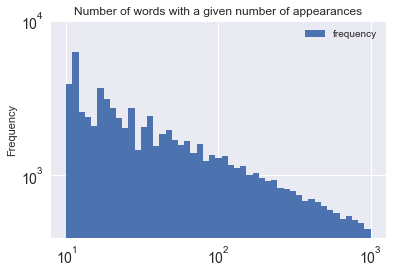

In [82]:
df_tot.plot(kind='hist',
                       bins=np.logspace(1,3,50),
                       loglog=True,
                       title='Number of words with a given number of appearances',
                       fontsize=14, yticks=[1000,10000])
plt.show()

#### Exploring languages in the Dataset. 

In [89]:
if 1 == 0: #I ran this portion in AWS and reimported into my notebook
    rest_revs['lang'] = rest_revs.text.map(lambda x: (lang_detector(x)))
else: #
    rest_revs = pd.read_csv('/Users/jackcunningham/Documents/capstone_data/yelp/rest_revs_cln2.csv')

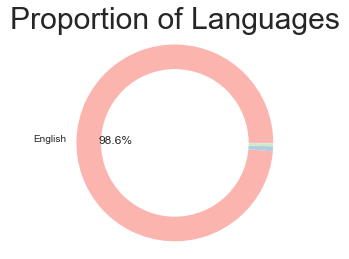

,lang,count
0,en,2886919
1,de,23850
2,fr,13902
3,es,1267
4,it,337
5,ja,290
6,nl,143
7,zh-cn,143
8,pt,120
9,af,100


In [90]:
def lang_detector(value):
        try:
            return detect(value)
        except:
            pass

if 1 == 0: #I ran this portion in AWS and reimported into my notebook
    rest_revs['lang'] = rest_revs.text.map(lambda x: (lang_detector(x)))
else: #
    rest_revs = pd.read_csv('/Users/jackcunningham/Documents/capstone_data/yelp/rest_revs_cln2.csv')

langt = pd.DataFrame(rest_revs.lang.value_counts()).head(10)
langt.reset_index(level=0, inplace=True)
langt.columns = ['lang', 'count']
count_list = (langt['count']).tolist()

from palettable.colorbrewer.qualitative import Pastel1_7

langt = pd.DataFrame(rest_revs.lang.value_counts()).head(10)
langt.reset_index(level=0, inplace=True)
langt.columns = ['lang', 'count']
count_list = (langt['count']).tolist()

def my_autopct(pct):
    return ('%.1f'% pct) + '%' if pct > 98 else ''

labels = ['English','','','','','','','','','']
counts = count_list
colors=Pastel1_7.hex_colors

plt.pie(counts, labels=labels, colors = colors,
        autopct=my_autopct, shadow=False)

plt.title('Proportion of Languages', fontsize=30)
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.75, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.figure(figsize=(20,10))
plt.show() 
display(langt)

##### Create a new DF removing outliers identified in the EDA;

In [185]:
#98.6% of the data is english.

#lets remove text with len< 2 and len > 2000 and non english language;
rest_revs_cln = rest_revs[(rest_revs.text_len > 2)&(rest_revs.text_len < 2000)]
rest_revs_cln = rest_revs[rest_revs.lang == 'en']
#the above has removed 40940 observations. 


In [190]:
if 1 == 0:
    rest_revs_cln.to_csv("rest_revs_cln.csv", encoding='utf-8', index = False)

In [ ]:
#############################################################################

### STEP 4 building the model
### (NB for grading;
##### some of my functions have taken too long to run, I have specified where this is the case.  I have so far intepreted the Linear Regression model)




In [92]:
rest_revs_cln = pd.read_csv('/Users/jackcunningham/Documents/capstone_data/yelp/rest_revs_cln.csv')

##### The Baseline. 

For any classifcation model, it is essential to outline the baseline accuracy.

Baseline Accuracy: The accuracy that can be achieved by a model by simply guessing the majority class for every observation.
> ** baseline_accuracy = majority_class_N / total_N

In [93]:
p_star_5 = float(rest_revs_cln[(rest_revs_cln.stars == 5)].shape[0]) / (rest_revs_cln.shape[0])* 100
print "{0:.2f} % of the stars are rated 5".format(p_star_5)

37.06 % of the stars are rated 5


We need to ensure that the predicting model has a classification accuracy score greater than 0.37. This is because, using the baseline, we can correctly classify a 5 star review at random 37% of the time. 

In [94]:
#Let's add some words observed in our most frequent analysis;
custom_stop_words = list(ENGLISH_STOP_WORDS)
custom_stop_words.append('just like')
custom_stop_words.append('like')
custom_stop_words.append('just')

First split the data set into variables and targets, and again into training and testing sets,

In [95]:
#to statify? 
X = rest_revs_cln.text
y = rest_revs_cln.stars

#split into training and testing sets; 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=1)


#statify;; balance the clases

In [96]:
#take a random look.
rest_revs_cln.iloc[89,:].text

'Typical Red Lobster.  Busy.  Good service. Food is delish.... cant get enough of those biscuits!'

In [197]:
rest_revs_cln[rest_revs_cln.stars == 3]

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,categories,text_len,lang
7,duHFBe87uNSXImQmvBh87Q,2,2011-08-31,2.0,mv-H-7Vpu_2xtOjRFiqH6g,3,What? am I really FTR on this? huh. weird.\...,2.0,qibGLHABNReGeJr2w4_8yQ,"[Sandwiches, Restaurants]",735,en
15,SDMRxmcKPNt1AHPBKqO64Q,0,2016-04-10,0.0,fT9506-dhjrMTmYLJO0xmg,3,I am an avid Applebees fan. In high school I u...,0.0,4i0NQ2eyuQZKpXbz8TxBEg,"[Burgers, Bars, Restaurants, Sports Bars, Nigh...",599,en
33,SDMRxmcKPNt1AHPBKqO64Q,0,2011-05-22,0.0,VdBbrOzYAhGQh0w2lu0TOg,3,Had an early lunch here this afternoon with th...,0.0,B7_ARdKo_GT-gjCSRGErXA,"[Burgers, Bars, Restaurants, Sports Bars, Nigh...",646,en
35,iFEiMJoEqyB9O8OUNSdLzA,0,2011-08-28,0.0,jNNjgNtqTwrc5w5IRBGkQA,3,Good (and only to my knowledge) Chinese take o...,0.0,eSlvR2rZ3HB1xNeQIPse8A,"[Chinese, Restaurants]",331,en
36,iFEiMJoEqyB9O8OUNSdLzA,0,2013-09-22,0.0,XK3dX3qrdSuOPSJXoPfSeQ,3,My family comes here after church once or twic...,0.0,4B2Ej2BbOvgxhdssRR2p4g,"[Chinese, Restaurants]",356,en
37,iFEiMJoEqyB9O8OUNSdLzA,0,2016-03-19,0.0,XGaxdTYZIFLb_Ot78Vfzog,3,Pretty standard Chinese food. Never had a bad...,0.0,HW3ksR6IptVfhVHYgZhJkw,"[Chinese, Restaurants]",123,en
40,HmI9nhgOkrXlUr6KZGZZew,7,2015-04-10,5.0,oCZkDpwJhUY9qHqrZfA_fg,3,"Rocky's is the kind of place my family loves, ...",7.0,Ic6-gs1_FjrWGx6JIr95Mw,"[Sandwiches, Restaurants, Italian, Diners, Bre...",1084,en
42,HmI9nhgOkrXlUr6KZGZZew,0,2014-06-10,0.0,kZRM5zzXG8kWhM4TfIUN5A,3,"Cheap, fast, and simple.\nCoffee was a little ...",0.0,YtfoTQbND5lY7lXnI-lc7A,"[Sandwiches, Restaurants, Italian, Diners, Bre...",143,en
43,HmI9nhgOkrXlUr6KZGZZew,0,2017-01-16,0.0,mh0dZv_sCFT6pVyyb8C7Rw,3,Breakfast is good but the service is a little ...,0.0,fVAr-9ICfZMfJk9ow95cBg,"[Sandwiches, Restaurants, Italian, Diners, Bre...",180,en
47,HmI9nhgOkrXlUr6KZGZZew,0,2014-10-24,0.0,FzHZ3qUStTwaD2P2ge9F9g,3,"I heard that ""The Earth without Art is just Eh...",0.0,C2uHg9HwI05pfaEhWCjuIA,"[Sandwiches, Restaurants, Italian, Diners, Bre...",443,en


### Hyper Parameterizing Models;
-  I'l; be using TFIDVectorizer... and investigate LR and MNB..

- TFID, or term frequency inverse document frequency score gives words which are most discriminating between documents. 

Words that occur alot in one documents but don't occur in many documents, contain a great deal of discriminating power.



In [102]:
#Hyperparameters LR & MNB

if 1 == 0: #the following is in py3 nb on AWS CPU 4 ECU 13  memory 16
    pipelineLR = Pipeline([
        ['vect', TfidfVectorizer(stop_words=custom_stop_words)],
        ['lr', LogisticRegression()],
    ])

    parametersLR = {
        'vect__max_df': [0.5, 1], 
        'vect__max_features' : [5000, 10000],
        'vect__ngram_range': [(1, 1), (1, 2)],  
        'lr__penalty': ["l1", "l2"],
    }

    pipelineMNB = Pipeline([
        ['vect', TfidfVectorizer(stop_words=custom_stop_words)],
        ['mNB', MultinomialNB()],
    ])

    parametersMNB = {
        'vect__max_df': [0.5, 1], 
        'vect__max_features' : [5000, 10000],
        'vect__ngram_range': [(1, 1), (1, 2)],
        'mNB__alpha': [0.00001, 0.000001],
    }


    grid_searchLR = GridSearchCV(pipelineLR, parametersLR, n_jobs=1, verbose=1, cv=3)
    grid_searchMNB = GridSearchCV(pipelineMNB, parametersMNB, n_jobs=1, verbose=1, cv=3)

    #For LR

    listLR = []

    listLR.append("Performing grid search on LR...")
    listLR.append(("pipelineLR:", [name for name, _ in pipelineLR.steps]))
    listLR.append(("parametersLR:"))
    listLR.append(parametersLR)
    t0 = time()
    #### fit it
    grid_searchLR.fit(X_train, y_train)
    listLR.append(("done in %0.3fs" % (time() - t0)))
    listLR.append(("Best score: %0.3f" % grid_searchLR.best_score_))
    #### get best parametersLR
    listLR.append(("Best parametersLR set:"))
    best_parametersLR = grid_searchLR.best_estimator_.get_params()
    for param_nameLR in sorted(parametersLR.keys()):
        listLR.append(("\t%s: %r" % (param_nameLR, best_parametersLR[param_nameLR])))

    thefileL = open('LRoutput.txt', 'w')
    for item in listLR:
        thefileL.write(str(item))

    ##### for MNB

    listMNB = []

    listMNB.append("Performing grid search on MNB...")
    listMNB.append(("pipelineMNB:", [name for name, _ in pipelineMNB.steps]))
    listMNB.append(("parametersMNB:"))
    listMNB.append(parametersMNB)
    t0 = time()
    #### fit it
    grid_searchMNB.fit(X_train, y_train)
    listMNB.append(("done in %0.3fs" % (time() - t0)))
    listMNB.append(("Best score: %0.3f" % grid_searchMNB.best_score_))
    #### get the best parametersMNB
    listMNB.append(("Best parametersMNB set:"))
    best_parametersMNB = grid_searchMNB.best_estimator_.get_params()
    for param_nameMNB in sorted(parametersMNB.keys()):
        listMNB.append(("\t%s: %r" % (param_nameMNB, best_parametersMNB[param_nameMNB])))

    thefileM = open('MNBoutput.txt', 'w')
    for item in listMNB:
        thefileM.write(str(item))
        
        
LRHYPE = open("LRoutput.txt" , 'r')
MNBHYPE = open("MNBoutput.txt" , 'r')

print LRHYPE.readlines()
print
print MNBHYPE.readlines()

["Performing grid search on LR...('pipelineLR:', ['vect', 'lr'])parametersLR:{'vect__max_df': [0.5, 1], 'vect__max_features': [5000, 10000], 'vect__ngram_range': [(1, 1), (1, 2)], 'lr__penalty': ['l1', 'l2']}done in 29706.604sBest score: 0.632Best parametersLR set:\tlr__penalty: 'l1'\tvect__max_df: 0.5\tvect__max_features: 10000\tvect__ngram_range: (1, 2)"]

["['Performing grid search on MNB...',\n", " ('pipelineMNB:', ['vect', 'mNB']),\n", " 'parametersMNB:',\n", " {'mNB__alpha': [1e-05, 1e-06],\n", "  'vect__max_df': [0.5, 1],\n", "  'vect__max_features': [5000, 10000],\n", "  'vect__ngram_range': [(1, 1), (1, 2)]},\n", " 'done in 20095.274s',\n", " 'Best score: 0.589',\n", " 'Best parametersMNB set:',\n", " '\\tmNB__alpha: 1e-05',\n", " '\\tvect__max_df: 0.5',\n", " '\\tvect__max_features: 10000',\n", " '\\tvect__ngram_range: (1, 2)']\n"]


In [98]:
if 1 == 0: #the following is in py3 nb on AWS CPU 4 ECU 13  memory 16
    tfid_lr_mod_H = make_pipeline(TfidfVectorizer(stop_words=custom_stop_words,
                                                  max_df=0.5,
                                                  max_features=10000,
                                                  ngram_range=(1, 2)
                                                 ),
                                  LogisticRegression(penalty='l1'),
                                 )

    tfid_lr_mod_H = tfid_lr_mod_H.fit(X_train, y_train)

    with open('tfid_lr_mod_H.pkl', 'wb') as fL:
        pickle.dump(tfid_lr_mod_H, fL, protocol=2) #for py2 nb


    tfid_MNB_mod_H = make_pipeline(TfidfVectorizer(stop_words=custom_stop_words,
                                                  max_df=0.5,
                                                  max_features=10000,
                                                  ngram_range=(1, 2)
                                                 ),
                                  MultinomialNB(alpha=0.00001),
                                 )

    tfid_MNB_mod_H = tfid_MNB_mod_H.fit(X_train, y_train)

    with open('tfid_MNB_mod_H.pkl', 'wb') as fM:
        pickle.dump(tfid_MNB_mod_H, fM, protocol=2) #for py2 nb

with open('/Users/jackcunningham/Documents/capstone_data/yelp/models/tfid_lr_mod_H.pkl') as fL:
    tfid_lr_mod_H = pickle.load(fL)

with open('/Users/jackcunningham/Documents/capstone_data/yelp/models/tfid_MNB_mod_H.pkl') as fM:
    tfid_MNB_mod_H = pickle.load(fM)


/Users/jackcunningham/anaconda2/lib/python2.7/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/jackcunningham/anaconda2/lib/python2.7/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/jackcunningham/anaconda2/lib/python2.7/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/jackcunningham/anaconda2/lib/python2.7/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator Pipeline from version 0.19.1 when using versi

##### Confusion Matrix

The confusion matrix represents the performance of a model in classifying labels. 

It demonstrates in a table, a comparison between observed classes (in this case stars) versus the prediction class. 

The confusion matrix allows us to demonstrate where our model is correctly and incorrectly predicting the class, star rating. 

##### Accuracy

The classifer accuracy can be calculated as; 
> **accuracy = (tp + tn) / total_population**

Where tp = True positive and tn = True negative. 
The above is true for a binary model. 

##### Classification Report. 

The classification report prints out three metrics precision; recall, F1 score and "support";
- precision; measures out of all the times the classifier predicted a positive label, the true label was also positive.
- recall; measures out of all the times the true label was positive, the predicted label was also positive.
- F1 score; The F1-score is the harmonic mean of the precision and recall metrics
- "Support"; refers to the total number of observations in each class

In [44]:
tfid_lr_mod_H_y_pred = tfid_lr_mod_H.predict(X_test)
print accuracy_score(y_test, tfid_lr_mod_H_y_pred)
print "Number of features: \n", len(tfid_lr_mod_H.steps[0][1].get_feature_names())
print "Classification Report: \m"
print classification_report(y_test,tfid_lr_mod_H_y_pred,target_names=[str(i) + ' Star' for i in range(1,6)])

tfid_lr_mod_H_conmat = pd.DataFrame(np.array(confusion_matrix(y_test, tfid_lr_mod_H_y_pred)), index=['is_one_star', 'is_two_star','is_three_star','is_four_star','is_five_star'],
                         columns=['p_one_star', 'p_two_star','p_three_star','p_four_star','p_five_star' ])
print "Confusion Matrix: "
display(tfid_lr_mod_H_conmat)

0.634392362795
Number of features: 
10000
Classification Report: \m
             precision    recall  f1-score   support

     1 Star       0.69      0.79      0.74     79771
     2 Star       0.53      0.34      0.41     70495
     3 Star       0.54      0.39      0.45    102654
     4 Star       0.55      0.55      0.55    201338
     5 Star       0.71      0.83      0.76    267472

avg / total       0.62      0.63      0.62    721730

Confusion Matrix: 


,p_one_star,p_two_star,p_three_star,p_four_star,p_five_star
is_one_star,62932,9549,3032,2081,2177
is_two_star,19654,23647,17204,6904,3086
is_three_star,5727,9963,40037,38140,8787
is_four_star,1733,1375,12637,110131,75462
is_five_star,1189,363,1762,43045,221113


In [251]:
#CHANGE to NMB 
tfid_MNB_mod_H_y_pred = tfid_MNB_mod_H.predict(X_test)
print accuracy_score(y_test, tfid_MNB_mod_H_y_pred)
print "Number of features: \n", len(tfid_MNB_mod_H.steps[0][1].get_feature_names())
print "Classification Report: \m"
print classification_report(y_test,tfid_MNB_mod_H_y_pred,target_names=[str(i) + ' Star' for i in range(1,6)])

tfid_MNB_mod_H_conmat = pd.DataFrame(np.array(confusion_matrix(y_test, tfid_MNB_mod_H_y_pred)), index=['is_one_star', 'is_two_star','is_three_star','is_four_star','is_five_star'],
                         columns=['p_one_star', 'p_two_star','p_three_star','p_four_star','p_five_star' ])
print "Confusion Matrix: "
display(tfid_MNB_mod_H_conmat)

0.58980920843
Number of features: 
10000
Classification Report: \m
             precision    recall  f1-score   support

     1 Star       0.64      0.71      0.67     79771
     2 Star       0.47      0.23      0.31     70495
     3 Star       0.48      0.25      0.32    102654
     4 Star       0.48      0.54      0.51    201338
     5 Star       0.68      0.82      0.74    267472

avg / total       0.57      0.59      0.57    721730

Confusion Matrix: 


,p_one_star,p_two_star,p_three_star,p_four_star,p_five_star
is_one_star,56640,10212,3919,5350,3650
is_two_star,19101,16022,16857,13951,4564
is_three_star,7831,6218,25222,51874,11509
is_four_star,3053,1084,6193,109055,81953
is_five_star,2511,268,731,45218,218744


##### Intepretation of the Logisitc Regression Model: tfid_lr_mod

Interpreting the confusion matrix, we see that 21449 times the model correctly predicted a two star rating. In 20482 cases, the model incorrectly identified a one star review, where in actual fact, each time the review was a two star review.

Reffering to the initial interpretation of the classication report, and the metrics contained, we can say 67% of the classifier predicting 5 star, the actual star rating was 5.


In [87]:
#binarize to show roc predicting class or any other class;
S1_pred_binz = y_test.map(lambda x: 1 if x==1 else 0)


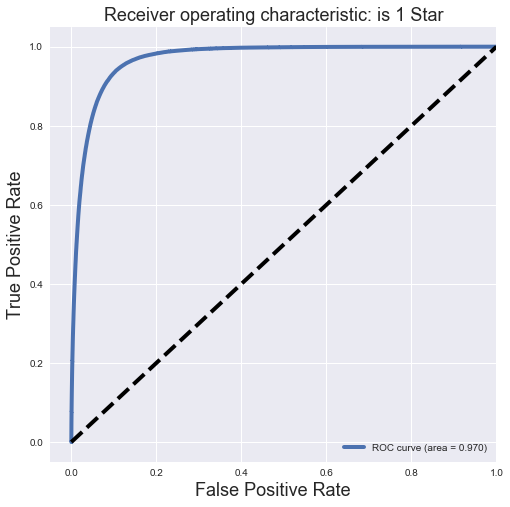

In [88]:

#precicting class 1 or 5!
    #fpr, tpr, threshold = roc_curve(preditons_binarized, tflrm_yhat_pp[:,1])
fpr, tpr, threshold = roc_curve(S1_pred_binz, Y_pp['1_Star'])

roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is 1 Star', fontsize=18)
plt.legend(loc="lower right")
plt.show()

lets try reduce of false negatives in the classifation of 1_Star, i.e. we want to reduce predictions that ratings are higher than 1, when they are infact 1!

In [ ]:
Y_pp = pd.DataFrame(tfid_lr_mod_H.predict_proba(X_test), columns=['1_Star','2_Star', '3_Star', '4_Star', '5_Star'])

In [114]:
#S1_pred_binz = y_test.map(lambda x: 1 if x==1 else 0)

Y_pp['pred_1_Star_thresh10'] = [1 if x >= 0.10 else 0 for x in Y_pp['1_Star'].values]
S1_pred_binz_th = y_test.map(lambda x: 1 if x==1 else 0)



In [124]:
X = pd.DataFrame(np.array(confusion_matrix(S1_pred_binz_th, Y_pp.pred_1_Star_thresh10.values,labels=[1,0])), index=['is_one_star','is_not_one_star'], columns=['p_one_star', 'p_not_one_star'])#     

X

,p_one_star,p_not_one_star
is_one_star,75882,3889
is_not_one_star,76629,565330


In [ ]:
#get model feature names 

tfid_lr_mod_H.fit(X_train, y_train)
tfid_lr_mod_H.steps[0][1].get_featurenames()

tfid_lr_mod_H.steps
tfid_lr_mod_H.steps[1][1].


##### Applying the models; 

In [302]:
text = ["I loved how terrible the service was, it was incredibly funny. We has a really good time in the end though and the food was great. I would recommend going, but its not worth 5/5"]


In [277]:
def star_predictor_checker(text, model):
    my_pred = model.predict(text)[0]
    try:
        actual = rest_revs_cln[rest_revs_cln.text == text[0]].stars[0]
    except:
        actual = "N/A"
    print "Review: ", text
    print
    print "Model Prediction (Star rating): ", my_pred ,
    print 
    print "Actual Observation (Star rating): ", actual

In [303]:
print star_predictor_checker(text, tfid_lr_mod_H)

print star_predictor_checker(text, tfid_MNB_mod_H)


Review:  ['I loved how terrible the service was, it was incredibly funny. We has a really good time in the end though and the food was great. I would recommend going, but its not worth 5/5']

Model Prediction (Star rating):  5
Actual Observation (Star rating):  N/A
None
Review:  ['I loved how terrible the service was, it was incredibly funny. We has a really good time in the end though and the food was great. I would recommend going, but its not worth 5/5']

Model Prediction (Star rating):  5
Actual Observation (Star rating):  N/A
None


In [ ]:
#####################################################################

<div>Icons made by <a href="https://www.flaticon.com/authors/dave-gandy" title="Dave Gandy">Dave Gandy</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a> is licensed by <a href="http://creativecommons.org/licenses/by/3.0/" title="Creative Commons BY 3.0" target="_blank">CC 3.0 BY</a></div>